In [82]:
import config
import helper_functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import itertools    
from mysql.connector import errorcode

from sklearn import svm
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.externals.six import StringIO 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

from xgboost import XGBClassifier

from IPython.display import Image 
# import pydotplus

## Call DB to retrieve data and save to a dataframe

In [ ]:
db_name = config.db_name

In [ ]:
cnx = mysql.connector.connect(
    host=config.host,
    user=config.user,
    passwd=config.password,
    database=db_name,
    buffered=True
)

cursor = cnx.cursor()

In [ ]:
execute_statement = """
                    SELECT 
                            d.id, d.pk, d.annual_inc, d.more_than_50k, 
                            d.purpose, d.application_type, d.grade, d.home_ownership,
                            d.addr_state, d.zip_code, d.loan_amnt, d.emp_length,
                            d.tot_hi_cred_lim, d.fico_range_low, d.dti,
                            c.med_inc, c.pk, d.pk
                    FROM 
                            mod5_project.dataset_lendingclub AS d
                    LEFT JOIN 
                            mod5_project.zip_codes AS z
                    ON 
                            d.pk = z.pk1
                    LEFT JOIN 
                            mod5_project.census_median_income_data AS c
                    ON 
                            c.pk = z.pk
                    GROUP BY 
                            d.id
                    ;                    
                    """
cursor.execute(execute_statement)
df = cursor.fetchall()
column = ['id', 'pk', 'annual_inc', 'more_than_50k', 
          'purpose', 'application_type', 'grade', 'home_ownership', 
          'addr_state', 'zip_code', 'loan_amnt', 'emp_length', 
          'tot_hi_cred_lim', 'fico_range_low', 'dti',
          'med_inc_county', 'c.pk', 'z.pk'
         ]
df = pd.DataFrame(df, columns = column)

df = df[[  'id','annual_inc','more_than_50k','purpose',
           'application_type','grade','home_ownership','addr_state',
           'zip_code','loan_amnt','emp_length','tot_hi_cred_lim',
           'fico_range_low','dti', 'med_inc_county']]

df = df.dropna()
df

Initial count: 103723 rows × 15 columns
There were some rows that did not contain zipcodes from the webscraping and API calls performed

After dropping the NaN's: 84090 rows × 15 columns
A total of 19633 were dropped

### Saving df created to csv for faster calls

In [ ]:
filename = 'cleaned_df.csv'
df.to_csv(filename, index=False)

### Load from csv

In [180]:
df = pd.read_csv('cleaned_df.csv')

In [181]:
df.drop(['id','annual_inc','zip_code','addr_state'],axis=1, inplace=True)

In [182]:
df.head()

,more_than_50k,purpose,application_type,grade,home_ownership,loan_amnt,emp_length,tot_hi_cred_lim,fico_range_low,dti,med_inc_county
0,1,debt_consolidation,Joint App,B,MORTGAGE,35000.0,10.0,213475.0,700.0,10.67,35254.0
1,1,debt_consolidation,Individual,A,OWN,29000.0,0.0,88666.0,685.0,14.39,35254.0
2,0,credit_card,Joint App,A,OWN,9000.0,8.0,76269.0,720.0,37.13,40492.0
3,1,debt_consolidation,Individual,C,MORTGAGE,12000.0,10.0,131063.0,760.0,33.12,40492.0
4,0,credit_card,Individual,A,OWN,10000.0,4.0,52590.0,725.0,12.60,40492.0


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84090 entries, 0 to 84089
Data columns (total 11 columns):
more_than_50k       84090 non-null int64
purpose             84090 non-null object
application_type    84090 non-null object
grade               84090 non-null object
home_ownership      84090 non-null object
loan_amnt           84090 non-null float64
emp_length          84090 non-null float64
tot_hi_cred_lim     84090 non-null float64
fico_range_low      84090 non-null float64
dti                 84090 non-null float64
med_inc_county      84090 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 7.1+ MB


Target Variable
more_than_50k
0    21373
1    62717
Name: more_than_50k, dtype: int64


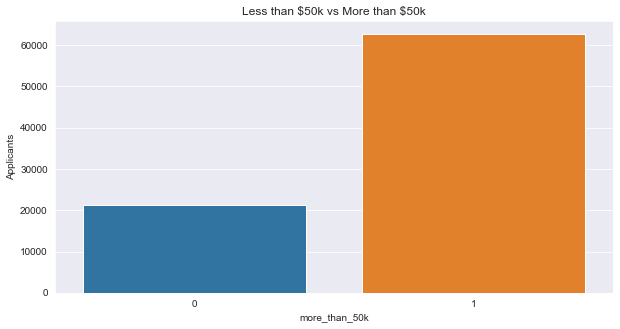

In [184]:
print('Target Variable')
print(df.groupby(['more_than_50k']).more_than_50k.count())

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['more_than_50k'])
plt.title('Less than \$50k vs More than \$50k')
plt.ylabel('Applicants')
plt.show()

### Baseline = 34%

# Unprocessed data

In [8]:
# Dirty (no categorical, no standardscaling)
X = df.loc[:, 'loan_amnt':'med_inc_county']
y = df['more_than_50k']

### Using StandardScaler() to Standardize features

In [185]:
scale = StandardScaler()
df[['loan_amnt','emp_length','tot_hi_cred_lim',
     'fico_range_low','dti', 'med_inc_county']] = scale.fit_transform(df[['loan_amnt','emp_length','tot_hi_cred_lim',
                         'fico_range_low','dti','med_inc_county']])

In [186]:
df.head()

,more_than_50k,purpose,application_type,grade,home_ownership,loan_amnt,emp_length,tot_hi_cred_lim,fico_range_low,dti,med_inc_county
0,1,debt_consolidation,Joint App,B,MORTGAGE,1.747736,1.165466,0.081957,-0.192733,-0.857260,-1.453094
1,1,debt_consolidation,Individual,A,OWN,1.167005,-1.423624,-0.643157,-0.627188,-0.513762,-1.453094
2,0,credit_card,Joint App,A,OWN,-0.768764,0.647648,-0.715181,0.386540,1.586004,-1.134076
3,1,debt_consolidation,Individual,C,MORTGAGE,-0.478399,1.165466,-0.396839,1.545087,1.215729,-1.134076
4,0,credit_card,Individual,A,OWN,-0.671976,-0.387988,-0.852751,0.531359,-0.679047,-1.134076


### One-Hot Encoding Categorical Columns 

In [187]:
df = pd.get_dummies(df, drop_first=True)

In [188]:
df.head()

,more_than_50k,loan_amnt,emp_length,tot_hi_cred_lim,fico_range_low,dti,med_inc_county,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,...,application_type_Joint App,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT
0,1,1.747736,1.165466,0.081957,-0.192733,-0.857260,-1.453094,0,1,0,...,1,1,0,0,0,0,0,1,0,0
1,1,1.167005,-1.423624,-0.643157,-0.627188,-0.513762,-1.453094,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,-0.768764,0.647648,-0.715181,0.386540,1.586004,-1.134076,1,0,0,...,1,0,0,0,0,0,0,0,1,0
3,1,-0.478399,1.165466,-0.396839,1.545087,1.215729,-1.134076,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,0,-0.671976,-0.387988,-0.852751,0.531359,-0.679047,-1.134076,1,0,0,...,0,0,0,0,0,0,0,0,1,0


# Processed Data

In [189]:
X = df.loc[:, 'loan_amnt':'home_ownership_RENT']
y = df['more_than_50k']

### Set TrainTestSplit

In [190]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

## Baseline DummyClassifier

In [282]:
model_dummy = DummyClassifier(strategy="uniform", random_state=1)
model_dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=1, strategy='uniform')

In [285]:
y_predict_dummy = model_dummy.predict(X_test)
print(f'Baseline Accuracy Score: {accuracy_score(y_test, y_predict_dummy) * 100:.2f}%')
print(f'Baseline Precision Score: {precision_score(y_test, y_predict_dummy) * 100:.2f}%')

Baseline Accuracy Score: 50.09%
Baseline Precision Score: 74.45%


In [286]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_random_forest),
    columns=['Predicted Not 50k', 'Predicted 50k'],
    index=['True Not 50k', 'True 50k']
)

,Predicted Not 50k,Predicted 50k
True Not 50k,1376,2950
True 50k,296,12196


DummyClassifier

Confusion Matrix, without normalization
[[2185 2141]
 [6253 6239]]


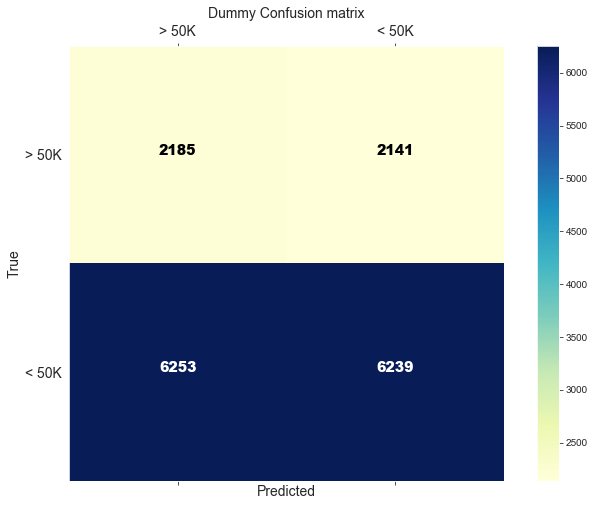

In [304]:
classes = ['> 50K','< 50K']
cm_dummy = confusion_matrix(y_test, y_predict_dummy)
helper_functions.plot_confusion_matrix(cm_dummy, classes, title='Dummy Confusion matrix', cmap=plt.cm.YlGnBu)

In [288]:
print(classification_report(y_test, y_predict_dummy))

              precision    recall  f1-score   support

           0       0.26      0.51      0.34      4326
           1       0.74      0.50      0.60     12492

    accuracy                           0.50     16818
   macro avg       0.50      0.50      0.47     16818
weighted avg       0.62      0.50      0.53     16818



In [289]:
cr_dummy = classification_report(y_test, y_predict_dummy, output_dict=True)
df_cr_dummy = pd.DataFrame(cr_dummy).transpose()
df_cr_dummy

,f1-score,precision,recall,support
0,0.342369,0.258948,0.505086,4326.000000
1,0.597834,0.744511,0.499440,12492.000000
accuracy,0.500892,0.500892,0.500892,0.500892
macro avg,0.470102,0.501729,0.502263,16818.000000
weighted avg,0.532123,0.619612,0.500892,16818.000000


## Decision Trees

In [16]:
model_decision_tree = DecisionTreeClassifier(max_depth = 9)
model_decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [17]:
y_predict_decision_tree = model_decision_tree.predict(X_test)
accuracy_score(y_test, y_predict_decision_tree)

0.828695445356166

In [18]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_decision_tree),
    columns=['Predicted Not 50k', 'Predicted 50k'],
    index=['True Not 50k', 'True 50k']
)

,Predicted Not 50k,Predicted 50k
True Not 50k,2151,2175
True 50k,706,11786


Decision Tree

Confusion Matrix, without normalization
[[ 2151  2175]
 [  706 11786]]


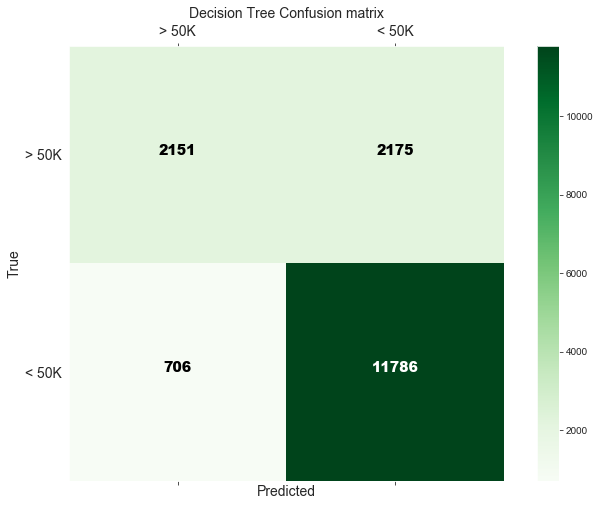

In [297]:
classes = ['> 50K','< 50K']
cm_decision_tree = confusion_matrix(y_test, y_predict_decision_tree)
helper_functions.plot_confusion_matrix(cm_decision_tree, classes, title='Decision Tree Confusion matrix', cmap=plt.cm.Greens)

In [19]:
print(classification_report(y_test, y_predict_decision_tree))

              precision    recall  f1-score   support

           0       0.75      0.50      0.60      4326
           1       0.84      0.94      0.89     12492

    accuracy                           0.83     16818
   macro avg       0.80      0.72      0.75     16818
weighted avg       0.82      0.83      0.82     16818



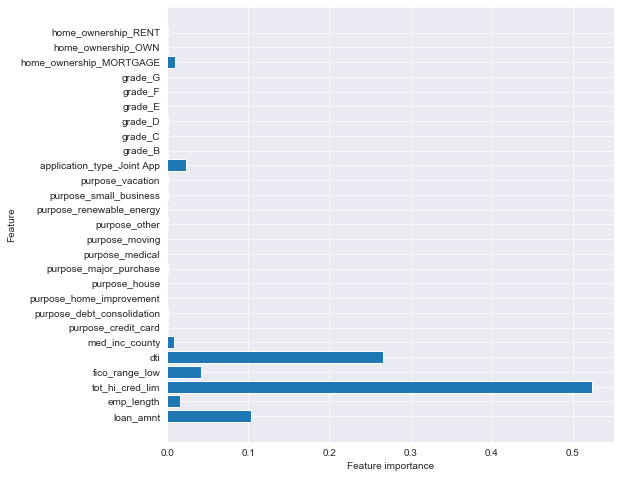

In [29]:
helper_functions.plot_feature_importances(model_decision_tree, X_train)

### Tuning Tree

[0.8248424398374126, 0.8281841188291157, 0.829658769672839, 0.829789721909087, 0.8262933214821538, 0.8238079040370283]


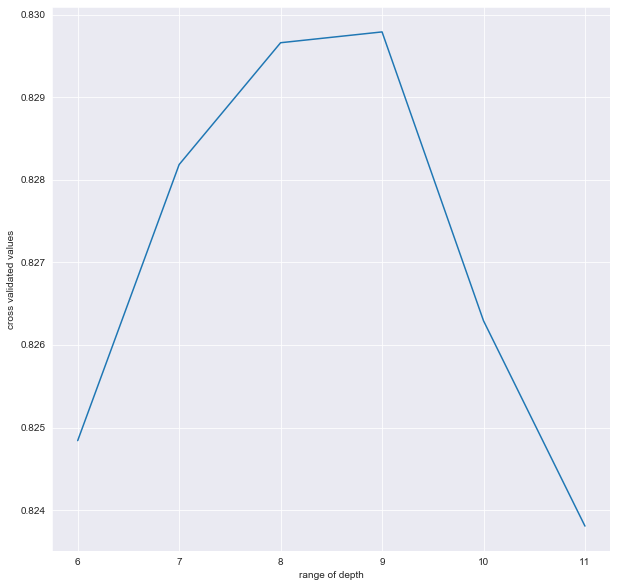

In [32]:
score = cross_val_score(model_decision_tree, X, y, cv = 15)
score.mean()
depth_range = range(6,12)
val = []
for depth in depth_range:
    model_decision_tree = DecisionTreeClassifier(max_depth = depth)
    depth_score = cross_val_score(model_decision_tree, X, y, cv = 15)
    val.append(depth_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(depth_range, val)
plt.xlabel('range of depth')
plt.ylabel('cross validated values')
plt.show()

## Random Forests

In [162]:
model_random_forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
model_random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [163]:
print(f'Random Forest Train Data: {model_random_forest.score(X_train, y_train) * 100:.2f}%')
print(f'Random Forest Test  Data: {model_random_forest.score(X_test, y_test) * 100:.2f}%')

Random Forest Train Data: 80.72%
Random Forest Test  Data: 80.70%


In [164]:
y_predict_random_forest = model_random_forest.predict(X_test)
print(f'Baseline Accuracy Score: {accuracy_score(y_test, y_predict_random_forest) * 100:.2f}%')
print(f'Baseline Precision Score: {precision_score(y_test, y_predict_random_forest) * 100:.2f}%')

Baseline Accuracy Score: 80.70%
Baseline Precision Score: 80.52%


In [167]:
model_random_forest_tuned = RandomForestClassifier(criterion='gini', max_depth=5, 
                                                  min_samples_leaf=0.05, min_samples_split=0.1, 
                                                  n_estimators=200)
model_random_forest_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.05, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [168]:
y_predict_random_forest_tuned = model_random_forest_tuned.predict(X_test)
print(f'Tuned Accuracy Score: {accuracy_score(y_test, y_predict_random_forest_tuned) * 100:.2f}%')
print(f'Tuned Precision Score: {precision_score(y_test, y_predict_random_forest_tuned) * 100:.2f}%')

Tuned Accuracy Score: 74.80%
Tuned Precision Score: 74.67%


In [68]:
y_predict_random_forest = model_random_forest.predict(X_test)
accuracy_score(y_test, y_predict_random_forest)

0.8009870376977049

In [69]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_random_forest),
    columns=['Predicted Not 50k', 'Predicted 50k'],
    index=['True Not 50k', 'True 50k']
)

,Predicted Not 50k,Predicted 50k
True Not 50k,1236,3090
True 50k,257,12235


Random Forest

Confusion Matrix, without normalization
[[ 1376  2950]
 [  296 12196]]


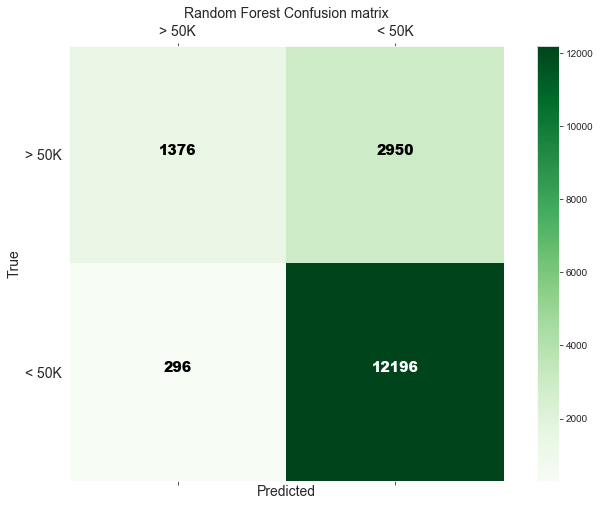

In [298]:
cm_random_forest = confusion_matrix(y_test, y_predict_random_forest)
helper_functions.plot_confusion_matrix(cm_random_forest, classes, title='Random Forest Confusion matrix', cmap=plt.cm.Greens)

In [199]:
print(classification_report(y_test, y_predict_random_forest))

              precision    recall  f1-score   support

           0       0.82      0.32      0.46      4326
           1       0.81      0.98      0.88     12492

    accuracy                           0.81     16818
   macro avg       0.81      0.65      0.67     16818
weighted avg       0.81      0.81      0.77     16818



In [203]:
cr_random_forest = classification_report(y_test, y_predict_random_forest, output_dict=True)
df_cr_random_forest = pd.DataFrame(cr_random_forest).transpose()
df_cr_random_forest

,f1-score,precision,recall,support
0,0.458820,0.822967,0.318077,4326.000000
1,0.882553,0.805229,0.976305,12492.000000
accuracy,0.806993,0.806993,0.806993,0.806993
macro avg,0.670686,0.814098,0.647191,16818.000000
weighted avg,0.773558,0.809792,0.806993,16818.000000


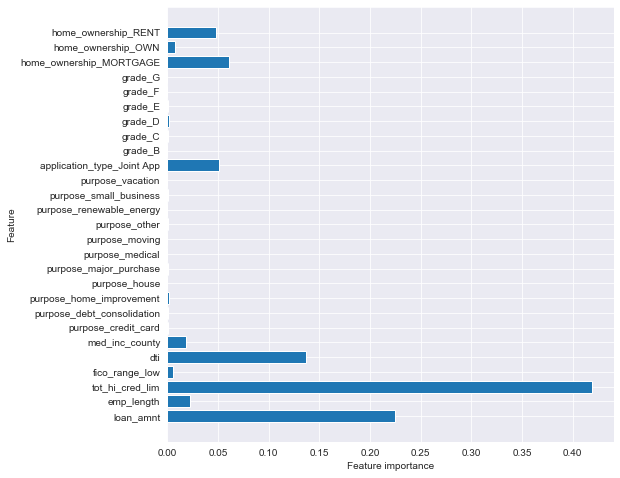

In [63]:
helper_functions.plot_feature_importances(model_random_forest, X_train)

## Tuning Random Forest

In [158]:
param_grid_random_forest = {
    'n_estimators': [100, 150],
    'criterion': ['entropy', 'gini'],
    'max_depth': [4, 5, 6],
    'min_samples_leaf':[0.05 ,0.1, 0.2],
    'min_samples_split':[0.05 ,0.1, 0.2]
}

In [159]:
%%time
grid_model_random_forest = GridSearchCV(estimator  = model_random_forest, 
                                        param_grid = param_grid_random_forest, 
                                        scoring    = 'precision', 
                                        cv         = 5, 
                                        n_jobs     = -1)

grid_model_random_forest.fit(X_train, y_train)

best_parameters = grid_model_random_forest.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_predict_random_forest = grid_model_random_forest.predict(X_train)
test_preds = grid_model_random_forest.predict(X_test)

training_accuracy = accuracy_score(y_train, y_predict_random_forest)
test_accuracy = accuracy_score(y_test, test_preds)

training_precision = precision_score(y_train, y_predict_random_forest)
test_precision = precision_score(y_test, test_preds)


print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Precision: {:.4}%'.format(training_precision * 100))
print('Validation Precision: {:.4}%'.format(test_precision * 100))

Grid Search found the following optimal parameters: 
criterion: 'gini'
max_depth: 5
min_samples_leaf: 0.05
min_samples_split: 0.1
n_estimators: 100

Training Accuracy: 74.71%
Validation accuracy: 74.31%
Training Precision: 74.7%
Validation Precision: 74.3%
Wall time: 2min 10s


## Logistic Regression

In [76]:
model_logistic_reg = LogisticRegression(solver='liblinear')
model_logistic_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
y_predict_logistic_reg = model_logistic_reg.predict(X_test)
accuracy_score(y_test, y_predict_logistic_reg)

0.8112141752883815

In [78]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_logistic_reg),
    columns=['Predicted Not 50k', 'Predicted 50k'],
    index=['True Not 50k', 'True 50k']
)

,Predicted Not 50k,Predicted 50k
True Not 50k,2155,2171
True 50k,1004,11488


Logistic Regression

Confusion Matrix, without normalization
[[ 2155  2171]
 [ 1004 11488]]


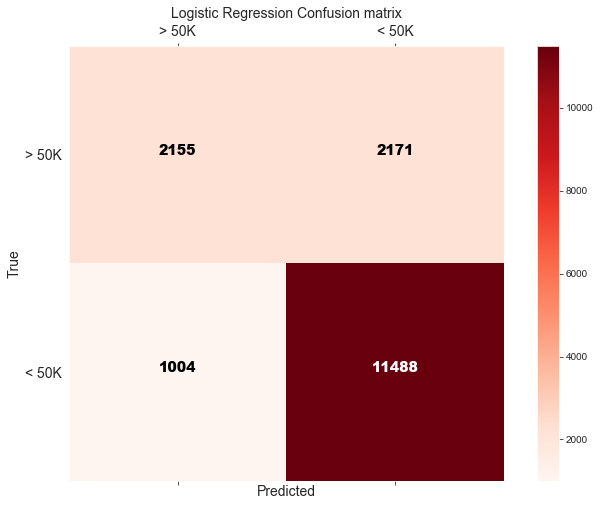

In [300]:
classes = ['> 50K','< 50K']
cm_logistic_reg = confusion_matrix(y_test, y_predict_logistic_reg)
helper_functions.plot_confusion_matrix(cm_logistic_reg, classes, title='Logistic Regression Confusion matrix', cmap=plt.cm.Reds)

In [80]:
print(classification_report(y_test, y_predict_logistic_reg))

              precision    recall  f1-score   support

           0       0.68      0.50      0.58      4326
           1       0.84      0.92      0.88     12492

    accuracy                           0.81     16818
   macro avg       0.76      0.71      0.73     16818
weighted avg       0.80      0.81      0.80     16818



# Add TUNING!!!!!!!!!

## XGBoost

In [83]:
model_xgboost = XGBClassifier()
model_xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [125]:
y_predict_xgboost = model_xgboost.predict(X_test)
print(f'Baseline Accuracy Score: {accuracy_score(y_test, y_predict_xgboost) * 100:.2f}%')
print(f'Baseline Precision Score: {precision_score(y_test, y_predict_xgboost) * 100:.2f}%')

Baseline Accuracy Score: 84.34%
Baseline Precision Score: 85.47%


In [118]:
model_xgboost_tuned = XGBClassifier(learning_rate=0.2, max_depth=10, 
                              min_child_weight=2, n_estimators=100, 
                              n_jobs=-1, subsample=0.7)
model_xgboost_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=2, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [126]:
y_predict_xgboost_tuned = model_xgboost_tuned.predict(X_test)
print(f'Tuned Accuracy Score: {accuracy_score(y_test, y_predict_xgboost_tuned) * 100:.2f}%')
print(f'Tuned Precision Score: {precision_score(y_test, y_predict_xgboost_tuned) * 100:.2f}%')

Tuned Accuracy Score: 83.38%
Tuned Precision Score: 86.14%


In [121]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_xgboost_tuned),
    columns=['Predicted Not 50k', 'Predicted 50k'],
    index=['True Not 50k', 'True 50k']
)

,Predicted Not 50k,Predicted 50k
True Not 50k,2467,1859
True 50k,936,11556


XGBoost

Confusion Matrix, without normalization
[[ 2467  1859]
 [  936 11556]]


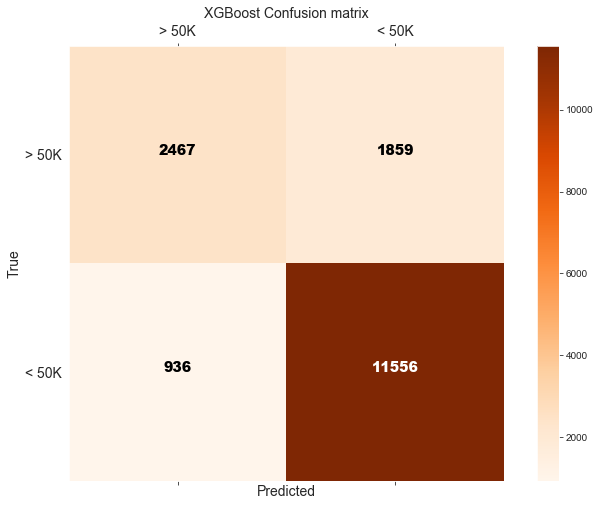

In [301]:
classes = ['> 50K','< 50K']
cm_xgboost = confusion_matrix(y_test, y_predict_xgboost_tuned)
helper_functions.plot_confusion_matrix(cm_xgboost, classes, title='XGBoost Confusion matrix', cmap=plt.cm.Oranges)

In [123]:
print(classification_report(y_test, y_predict_xgboost_tuned))

              precision    recall  f1-score   support

           0       0.72      0.57      0.64      4326
           1       0.86      0.93      0.89     12492

    accuracy                           0.83     16818
   macro avg       0.79      0.75      0.77     16818
weighted avg       0.83      0.83      0.83     16818



## Tuning XGBoost Gridsearch

In [108]:
param_grid = {
    'max_depth': [1, 10],
    'learning_rate': [0.1, 0.2],
    'n_jobs': [-1],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100, 150],
}

In [109]:
%%time
grid_model_xgboost = GridSearchCV(estimator  = model_xgboost, 
                                  param_grid = param_grid, 
                                  scoring    = 'precision', 
                                  cv         = 5, 
                                  n_jobs     = -1)

grid_model_xgboost.fit(X_train, y_train)

best_parameters = grid_model_xgboost.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_predict_xgboost = grid_model_xgboost.predict(X_train)
test_preds = grid_model_xgboost.predict(X_test)

training_accuracy = accuracy_score(y_train, y_predict_xgboost)
test_accuracy = accuracy_score(y_test, test_preds)

training_precision = precision_score(y_train, y_predict_xgboost)
test_precision = precision_score(y_test, test_preds)


print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Precision: {:.4}%'.format(training_precision * 100))
print('Validation Precision: {:.4}%'.format(test_precision * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 10
min_child_weight: 2
n_estimators: 100
n_jobs: -1
subsample: 0.7

Training Accuracy: 92.6%
Validation accuracy: 83.38%
Training Precision: 92.58%
Validation Precision: 86.14%
Wall time: 3min 22s


## Adaboost

In [127]:
model_adaboost = AdaBoostClassifier()
model_adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [128]:
y_predict_adaboost = model_adaboost.predict(X_test)
print(f'Baseline Accuracy Score: {accuracy_score(y_test, y_predict_adaboost) * 100:.2f}%')
print(f'Baseline Precision Score: {precision_score(y_test, y_predict_adaboost) * 100:.2f}%')

Baseline Accuracy Score: 82.25%
Baseline Precision Score: 85.54%


In [131]:
model_adaboost_tuned = AdaBoostClassifier(learning_rate = 1.0, n_estimators = 70)
model_adaboost_tuned.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=70, random_state=None)

In [132]:
y_predict_adaboost_tuned = model_adaboost_tuned.predict(X_test)
print(f'Tuned Accuracy Score: {accuracy_score(y_test, y_predict_adaboost_tuned) * 100:.2f}%')
print(f'Tuned Precision Score: {precision_score(y_test, y_predict_adaboost_tuned) * 100:.2f}%')

Tuned Accuracy Score: 82.43%
Tuned Precision Score: 85.56%


In [133]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_adaboost_tuned),
    columns=['Predicted Not 50k', 'Predicted 50k'],
    index=['True Not 50k', 'True 50k']
)

,Predicted Not 50k,Predicted 50k
True Not 50k,2389,1937
True 50k,1018,11474


Confusion Matrix, without normalization
[[ 2389  1937]
 [ 1018 11474]]


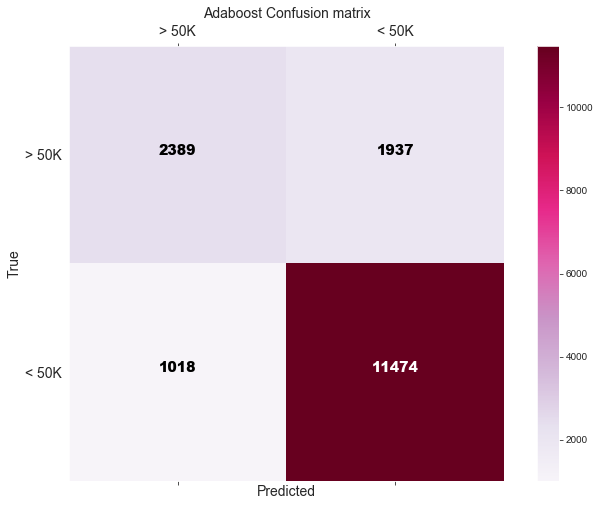

In [302]:
classes = ['> 50K','< 50K']
cm_adaboost = confusion_matrix(y_test, y_predict_adaboost_tuned)
helper_functions.plot_confusion_matrix(cm_adaboost, classes, title='Adaboost Confusion matrix', cmap=plt.cm.PuRd)

In [152]:
print(classification_report(y_test, y_predict_adaboost_tuned))

              precision    recall  f1-score   support

           0       0.70      0.55      0.62      4326
           1       0.86      0.92      0.89     12492

    accuracy                           0.82     16818
   macro avg       0.78      0.74      0.75     16818
weighted avg       0.82      0.82      0.82     16818



## Tuning Adaboost Gridsearch

In [129]:
param_grid_adaboost = {
    'n_estimators': [30, 50, 70],
    'learning_rate': [1.0, 0.5, 0.1],
}

In [130]:
%%time
grid_model_adaboost = GridSearchCV(estimator  = model_adaboost, 
                                   param_grid = param_grid_adaboost, 
                                   scoring    = 'precision', 
                                   cv         = 5, 
                                   n_jobs     = -1)

grid_model_adaboost.fit(X_train, y_train)

best_parameters = grid_model_adaboost.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_predict_adaboost = grid_model_adaboost.predict(X_train)
test_preds = grid_model_adaboost.predict(X_test)

training_accuracy = accuracy_score(y_train, y_predict_adaboost)
test_accuracy = accuracy_score(y_test, test_preds)

training_precision = precision_score(y_train, y_predict_adaboost)
test_precision = precision_score(y_test, test_preds)


print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Precision: {:.4}%'.format(training_precision * 100))
print('Validation Precision: {:.4}%'.format(test_precision * 100))

Grid Search found the following optimal parameters: 
learning_rate: 1.0
n_estimators: 70

Training Accuracy: 82.86%
Validation accuracy: 82.43%
Training Precision: 85.89%
Validation Precision: 85.56%
Wall time: 23.4 s


## Gradient Boost

In [141]:
model_gradient_boost = GradientBoostingClassifier()
model_gradient_boost.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [142]:
y_predict_gradient_boost = model_gradient_boost.predict(X_test)
print(f'Baseline Accuracy Score: {accuracy_score(y_test, y_predict_gradient_boost) * 100:.2f}%')
print(f'Baseline Precision Score: {precision_score(y_test, y_predict_gradient_boost) * 100:.2f}%')

Baseline Accuracy Score: 84.25%
Baseline Precision Score: 85.45%


In [147]:
model_gradient_boost_tuned = GradientBoostingClassifier(learning_rate = 0.5, max_depth = 5, n_estimators = 30)
model_gradient_boost_tuned.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [148]:
y_predict_gradient_boost_tuned = model_gradient_boost_tuned.predict(X_test)
print(f'Tuned Accuracy Score: {accuracy_score(y_test, y_predict_gradient_boost_tuned) * 100:.2f}%')
print(f'Tuned Precision Score: {precision_score(y_test, y_predict_gradient_boost_tuned) * 100:.2f}%')

Tuned Accuracy Score: 84.18%
Tuned Precision Score: 86.39%


In [149]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_gradient_boost_tuned),
    columns=['Predicted Not 50k', 'Predicted 50k'],
    index=['True Not 50k', 'True 50k']
)

,Predicted Not 50k,Predicted 50k
True Not 50k,2488,1838
True 50k,823,11669


Adaboost

Confusion Matrix, without normalization
[[ 2488  1838]
 [  823 11669]]


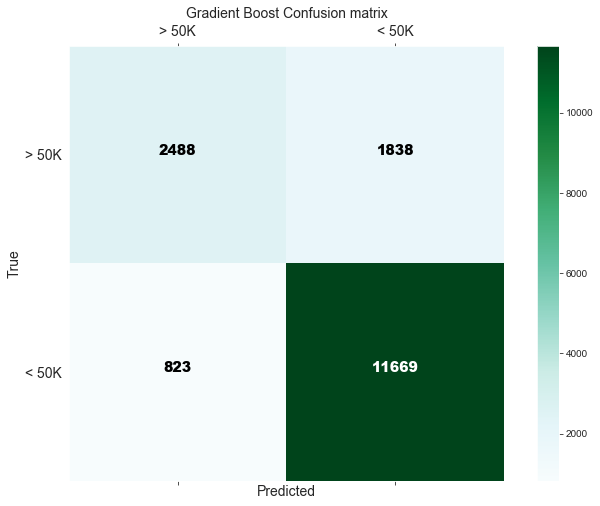

In [303]:
classes = ['> 50K','< 50K']
cm_gradient_boost = confusion_matrix(y_test, y_predict_gradient_boost_tuned)
helper_functions.plot_confusion_matrix(cm_gradient_boost, classes, title='Gradient Boost Confusion matrix', cmap=plt.cm.BuGn)

In [153]:
print(classification_report(y_test, y_predict_gradient_boost_tuned))

              precision    recall  f1-score   support

           0       0.75      0.58      0.65      4326
           1       0.86      0.93      0.90     12492

    accuracy                           0.84     16818
   macro avg       0.81      0.75      0.77     16818
weighted avg       0.83      0.84      0.83     16818



## Tuning Gradient Boost

In [145]:
param_grid_gradient_boost = {
    'learning_rate': [0.1, 0.5, 1.0],
    'n_estimators': [30, 100],
    'max_depth': [3,5]
}

In [146]:
%%time
grid_model_gradient_boost = GridSearchCV(estimator  = model_gradient_boost, 
                                         param_grid = param_grid_gradient_boost, 
                                         scoring    = 'precision', 
                                         cv         = 5, 
                                         n_jobs     = -1)

grid_model_gradient_boost.fit(X_train, y_train)

best_parameters = grid_model_gradient_boost.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_predict_gradient_boost = grid_model_gradient_boost.predict(X_train)
test_preds = grid_model_gradient_boost.predict(X_test)

training_accuracy = accuracy_score(y_train, y_predict_gradient_boost)
test_accuracy = accuracy_score(y_test, test_preds)

training_precision = precision_score(y_train, y_predict_gradient_boost)
test_precision = precision_score(y_test, test_preds)


print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Precision: {:.4}%'.format(training_precision * 100))
print('Validation Precision: {:.4}%'.format(test_precision * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.5
max_depth: 5
n_estimators: 30

Training Accuracy: 85.48%
Validation accuracy: 84.17%
Training Precision: 87.17%
Validation Precision: 86.38%
Wall time: 1min 18s


## Plotting ROC-Curve with all models for comparison

In [292]:
# Instantiate the classfiers and make a list
classifiers = [DummyClassifier(strategy="uniform", random_state=1),
               DecisionTreeClassifier(max_depth = 9),
               RandomForestClassifier(n_estimators=100, max_depth= 5),
               LogisticRegression(solver='liblinear'),
               XGBClassifier(learning_rate=0.2, max_depth=10, 
                              min_child_weight=2, n_estimators=100, 
                              n_jobs=-1, subsample=0.7),
               AdaBoostClassifier(learning_rate = 1.0, n_estimators = 70),
               GradientBoostingClassifier(learning_rate = 0.5, max_depth = 5, n_estimators = 30)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

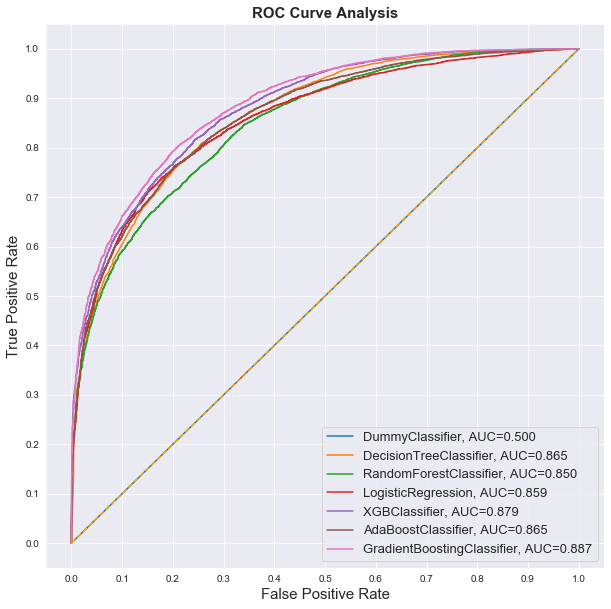

In [293]:
fig = plt.figure(figsize=(10,10))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()


In [294]:
y_predicts = [
    y_predict_dummy, y_predict_decision_tree, y_predict_random_forest,
    y_predict_logistic_reg, y_predict_xgboost_tuned,
    y_predict_adaboost_tuned, y_predict_gradient_boost_tuned
]

y_predict_names = [
    'Decision Tree', 'Random Forest',
    'Log Reg', 'XGBoost Tuned',
    'Adaboost Tuned', 'Gradient Boost Tuned'
]

list_of_f1s = []
for y_predict in y_predicts:
    cr_f_1 = classification_report(y_test, y_predict, output_dict=True)
    df_cr_f_1 = pd.DataFrame(cr_f_1).transpose()
    list_of_f1s.append(round(df_cr_f_1['f1-score']['accuracy'], 3))
    
list_of_f1s

[0.501, 0.829, 0.807, 0.811, 0.834, 0.824, 0.842]

Text(0.5, 1.0, 'F1 Scores Barplot')

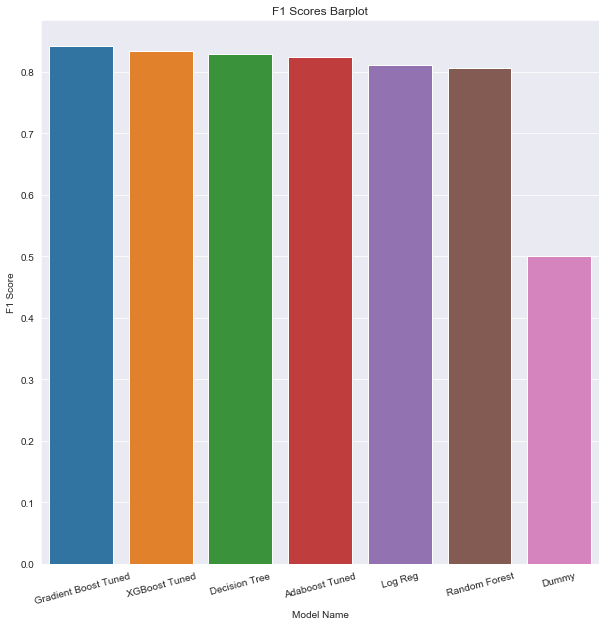

In [296]:
fig = plt.figure(figsize=(10,10))
sns.barplot(df_f1_scores['Model Name'], df_f1_scores['F1-Score'])
plt.xticks(rotation=15)
plt.ylabel('F1 Score')
plt.title('F1 Scores Barplot')

In [295]:
df_f1_scores = pd.read_excel('shared_assets/F1Scores.xlsx')
df_f1_scores

,Model Name,F1-Score
0,Gradient Boost Tuned,0.842
1,XGBoost Tuned,0.834
2,Decision Tree,0.829
3,Adaboost Tuned,0.824
4,Log Reg,0.811
5,Random Forest,0.807
6,Dummy,0.501
